In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import cv2
import numpy as np
from skimage import data, color, feature
import matplotlib.pyplot as plt
from skimage import transform

In [4]:
def make_data_from_folder(path):
  data = []
  for img in os.listdir(path):
      pic = cv2.imread(os.path.join(path,img))
      pic = cv2.cvtColor(pic,cv2.COLOR_BGR2RGB)
      # pic = cv2.resize(pic,(80,80))
      data.append(pic)
  return data

In [5]:
def plot_images(images):
  fig, ax = plt.subplots(3, 5, figsize=(32, 16))
  for i, axi in enumerate(ax.flat):
      axi.imshow(images[i], cmap='gray')
      axi.axis('off')

In [6]:
def apply_crop(images,x1,x2,y1,y2):
    #200:400,300:600
  return [img[x1:x2,y1:y2] for img in images]

In [7]:
def apply_gray(images):
  return [color.rgb2gray(img) for img in images]

In [8]:
def apply_gaussian(images):
    blured_images = [cv2.GaussianBlur(img, (15, 15), 0) for img in images]
    return blured_images

# Automatic brightness and contrast optimization with optional histogram clipping
def automatic_brightness_and_contrast(image, clip_hist_percent):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # Calculate grayscale histogram
    hist = cv2.calcHist([gray],[0],None,[256],[0,256])
    hist_size = len(hist)
    
    # Calculate cumulative distribution from the histogram
    accumulator = []
    accumulator.append(float(hist[0]))
    for index in range(1, hist_size):
        accumulator.append(accumulator[index -1] + float(hist[index]))
    
    # Locate points to clip
    maximum = accumulator[-1]
    clip_hist_percent *= (maximum/100.0)
    clip_hist_percent /= 2.0
    
    # Locate left cut
    minimum_gray = 0
    while accumulator[minimum_gray] < clip_hist_percent:
        minimum_gray += 1
    
    # Locate right cut
    maximum_gray = hist_size -1
    while accumulator[maximum_gray] >= (maximum - clip_hist_percent):
        maximum_gray -= 1
    
    # Calculate alpha and beta values
    alpha = 255 / (maximum_gray - minimum_gray)
    beta = -minimum_gray * alpha
    

    auto_result = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return (auto_result, alpha, beta)

In [9]:
def apply_auto_brightness_and_contrast(images, param):
  new_images = [automatic_brightness_and_contrast(img, param)[0] for img in images]
  return new_images

In [10]:
correct_data = make_data_from_folder('/content/drive/MyDrive/new_vizszint/correct')
incorrect_1_data = make_data_from_folder('/content/drive/MyDrive/new_vizszint/incorrect_1')
incorrect_2_data = make_data_from_folder('/content/drive/MyDrive/new_vizszint/incorrect_2')

pozitív tanító adatok:

In [11]:
# positive_patches = apply_gray(correct_data)
positive_patches = apply_crop(correct_data, 175, 475, 300, 600)
positive_patches = apply_auto_brightness_and_contrast(positive_patches, 10)
positive_patches = apply_gray(positive_patches)
positive_patches = np.stack(positive_patches, axis=0)
positive_patches.shape

(105, 300, 300)

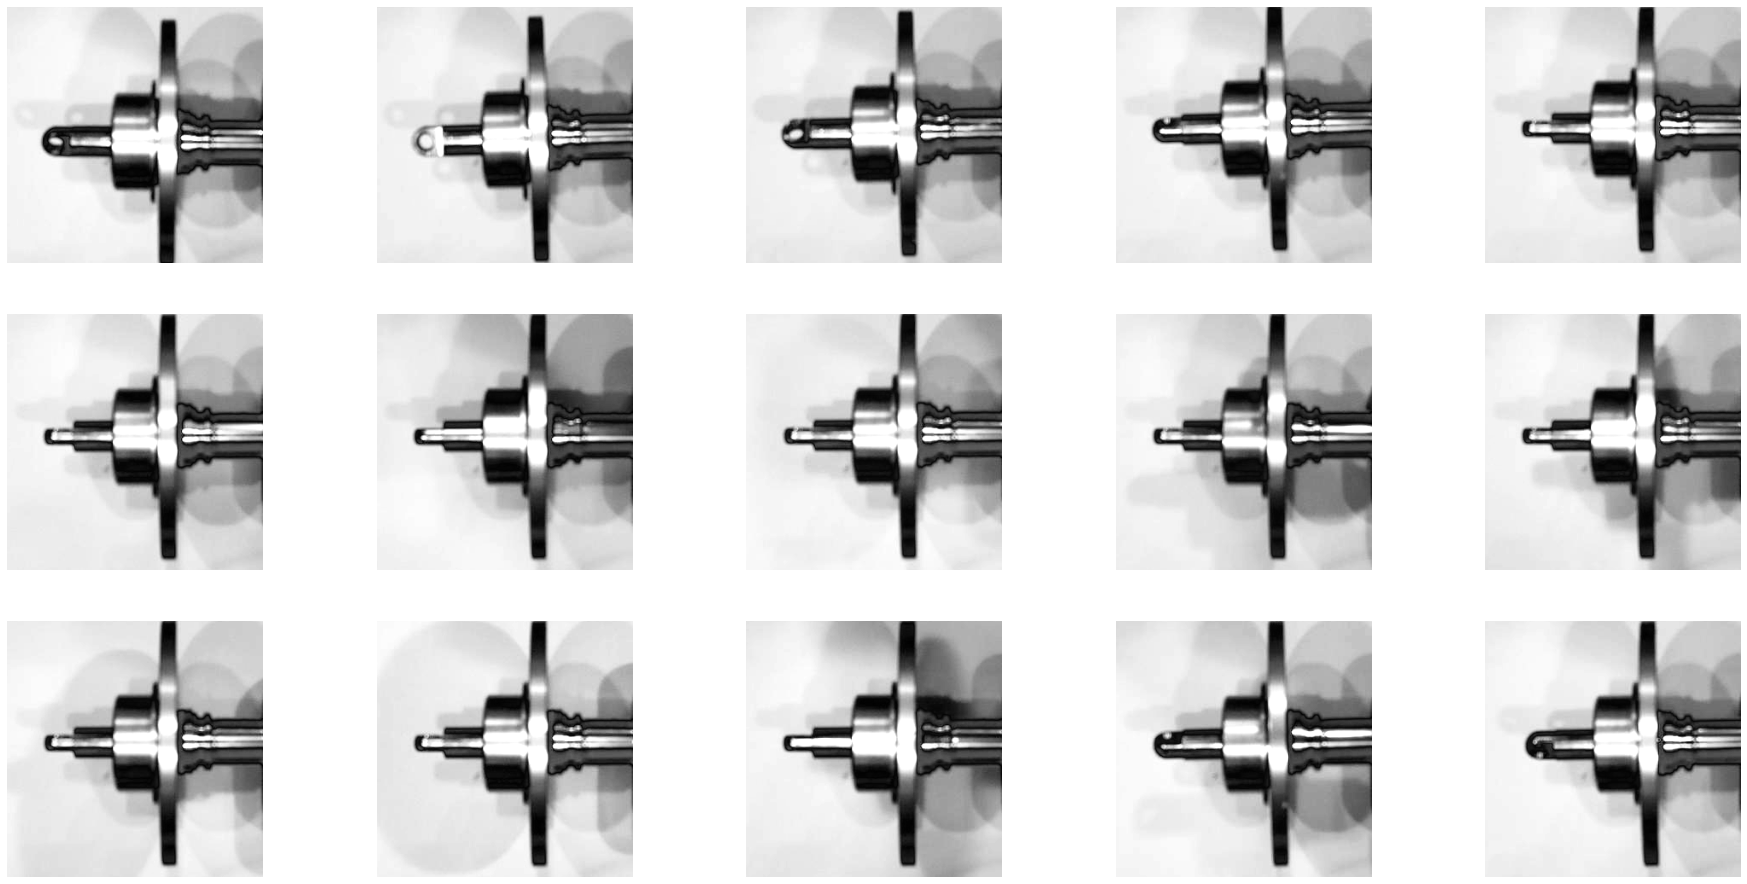

In [12]:
plot_images(positive_patches)

Negatív tanító adatok (magasabb):

In [13]:
# negative_1_patches = apply_gray(incorrect_1_data)
negative_1_patches = apply_crop(incorrect_1_data, 175, 475, 300, 600)
negative_1_patches = apply_auto_brightness_and_contrast(negative_1_patches, 25)
negative_1_patches = apply_gray(negative_1_patches)
negative_1_patches = np.stack(negative_1_patches, axis=0)
negative_1_patches.shape

(105, 300, 300)

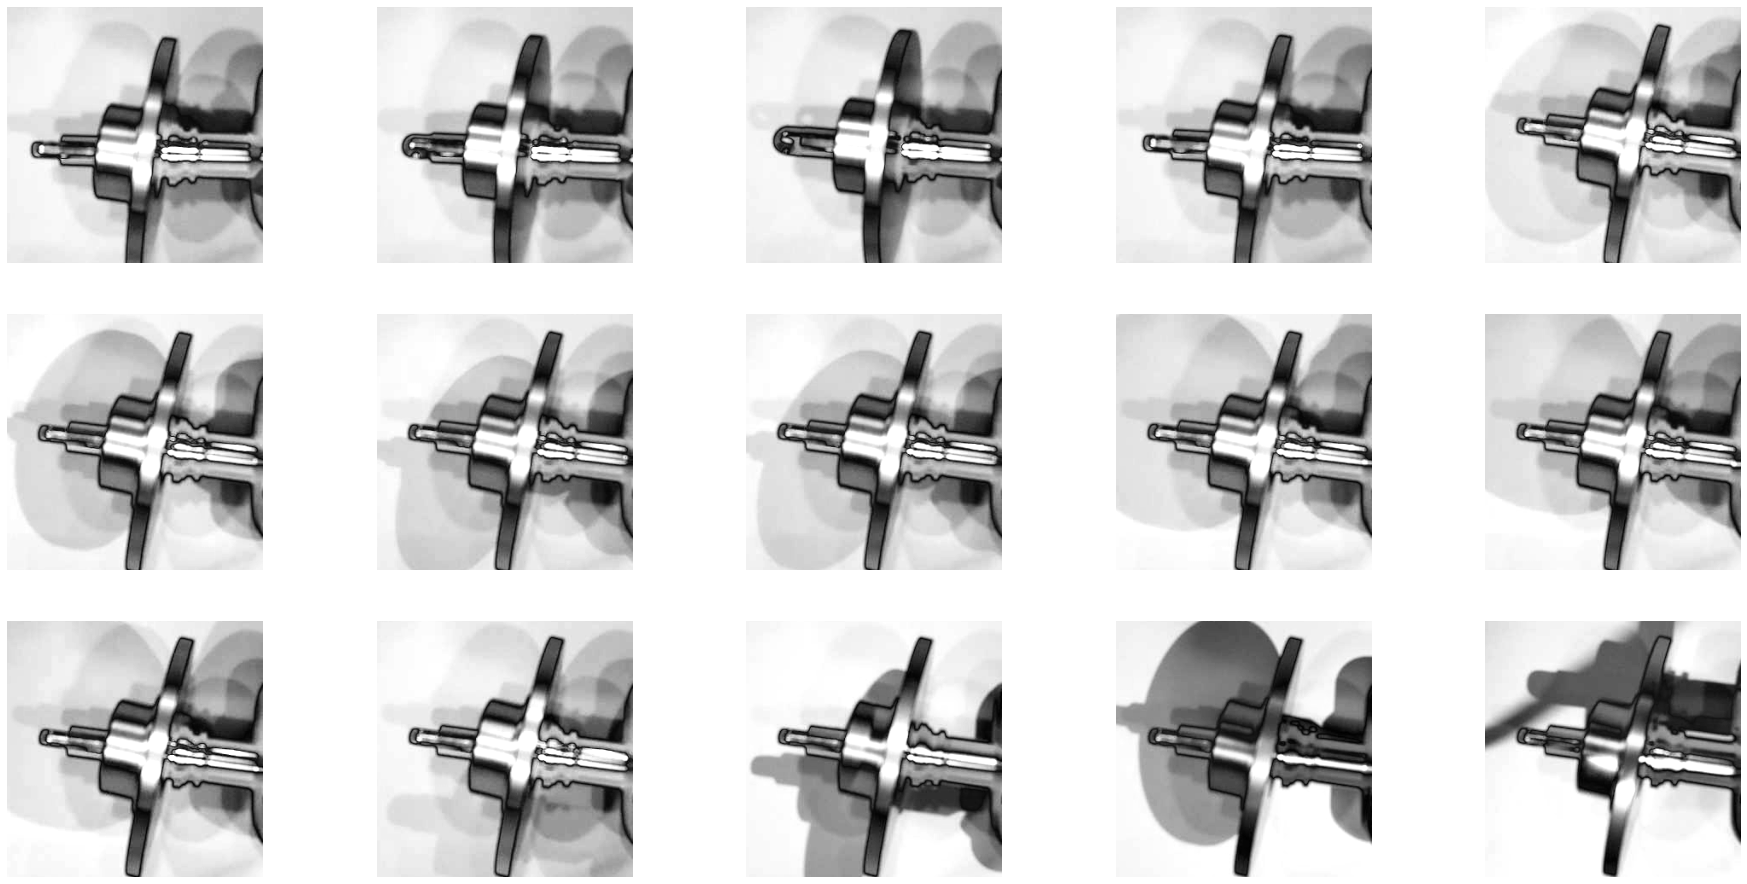

In [14]:
plot_images(negative_1_patches)

Negatív tanító adatok (ferde):

In [15]:
# negative_2_patches = apply_gray(incorrect_2_data)
negative_2_patches = apply_crop(incorrect_2_data, 175, 475, 300, 600)
negative_2_patches = apply_auto_brightness_and_contrast(negative_2_patches, 10)
negative_2_patches = apply_gray(negative_2_patches)
negative_2_patches = np.stack(negative_2_patches, axis=0)
negative_2_patches.shape

(105, 300, 300)

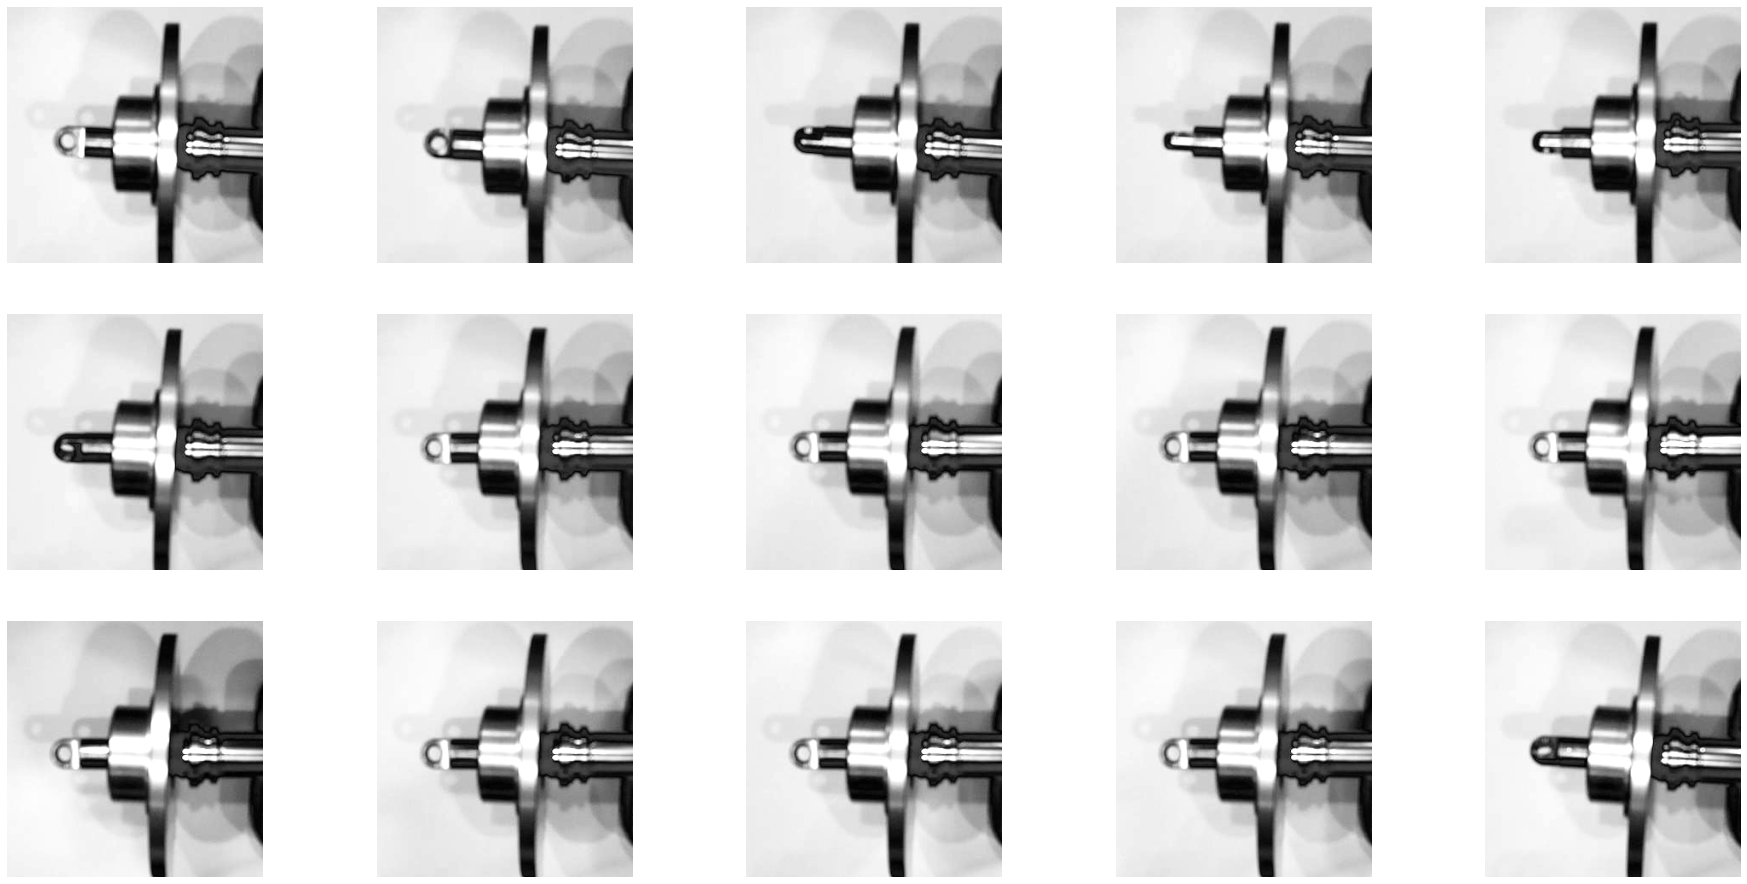

In [16]:
plot_images(negative_2_patches)

In [17]:
from itertools import chain
X = np.array([feature.hog(im)
                    for im in chain(positive_patches,
                                    negative_1_patches,
                                    negative_2_patches)])
y = np.zeros(X.shape[0])
y[:positive_patches.shape[0]] = 1
y[positive_patches.shape[0]:] = 2

In [18]:
X.shape

(315, 99225)

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

names = [
    "Nearest Neighbors",
    #"Linear SVM",
    #"RBF SVM",
    #"Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes"
    #"QDA",
]

classifiers = [
    KNeighborsClassifier(),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB()
    #QuadraticDiscriminantAnalysis(),
]

In [20]:
from sklearn.model_selection import cross_val_score

for i, cf in enumerate(classifiers):  
  print(f"{names[i]}: {cross_val_score(cf, X, y)}")

Nearest Neighbors: [0.88888889 0.87301587 0.87301587 0.73015873 0.80952381]
Decision Tree: [0.82539683 0.82539683 0.80952381 0.65079365 0.82539683]
Random Forest: [0.63492063 0.68253968 0.66666667 0.63492063 0.66666667]
Neural Net: [0.87301587 0.79365079 0.98412698 0.74603175 0.79365079]
AdaBoost: [0.87301587 0.92063492 0.98412698 0.9047619  0.96825397]
Naive Bayes: [0.76190476 0.77777778 0.77777778 0.6031746  0.76190476]


<h1>A knn osztályozóval megyünk tovább:<h1>

In [21]:
from sklearn.metrics import accuracy_score
def param_finder_knn(neighbors, X, y, algos):
  scores = [] 
  max_score = 0
  max_n = 0
  max_algo = ""

  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

  if type(neighbors) != int:
    for n in neighbors:
      model = KNeighborsClassifier(n_neighbors=n, algorithm=algos)
      model.fit(X_train,y_train)
      y_pred = model.predict(X_test)
      new_score = accuracy_score( y_test, y_pred)
      scores.append(new_score)
      if new_score > max_score:
        max_n = n
        max_score = new_score

    return scores, max_n
  else:
    for a in algos:
      model = KNeighborsClassifier(n_neighbors=neighbors, algorithm=a)
      model.fit(X_train,y_train)
      y_pred = model.predict(X_test)
      new_score = accuracy_score( y_test, y_pred)
      scores.append(new_score)
      if new_score > max_score:
        max_algo = a
        max_score = new_score

    return scores, max_algo
  

In [22]:
neighbors = [1,2,3,4,5,6,7,8,9,10]
scores, max_n = param_finder_knn(neighbors, X, y, "auto")
max_n

3

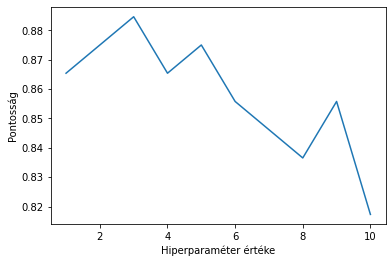

In [23]:
plt.plot(neighbors, scores)
plt.xlabel("Hiperparaméter értéke")
plt.ylabel("Pontosság")
plt.show()

Mivel azt kaptuk eredményül hogy az 1 az optimális hiperparaméter, így próbáljuk ki ezzel a paraméterrel a cross validációt.

In [24]:
new_model = KNeighborsClassifier(max_n)
cross_val_score(new_model, X, y)

array([0.9047619 , 0.92063492, 0.74603175, 0.76190476, 0.85714286])

Most az algoritmus típusát is próbáljuk végig:

In [25]:
algos = ["auto", "ball_tree", "kd_tree", "brute"]

scores, max_algo = param_finder_knn(max_n, X, y, algos)
max_algo

'auto'

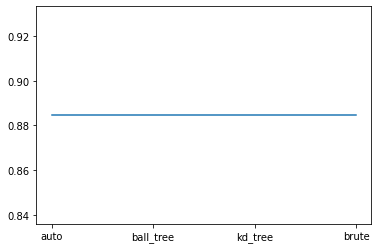

In [26]:
plt.plot(algos, scores)

In [27]:
scores

[0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846,
 0.8846153846153846]

Mivel az "auto" jött ki végeredménynek, így ezt nem kell újra próbálni, hiszen ez az alapértelmezett.

Nézzük meg a predikció igazságmátrixát:

[[30  5]
 [ 7 62]]


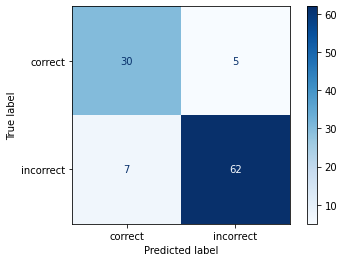

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

model = KNeighborsClassifier(n_neighbors=max_n, algorithm=max_algo)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        display_labels=["correct", "incorrect"],
        cmap=plt.cm.Blues
    )

print(disp.confusion_matrix)

# plt.imshow(confusion_matrix(y_test, y_pred))

Modell validálása:

In [29]:
from sklearn.model_selection import validation_curve
train_score, val_score = validation_curve(KNeighborsClassifier(), X, y, 
                                          param_name='n_neighbors', param_range=neighbors, cv=5)

Text(0.5, 1.0, 'plm seeger knn model validáció')

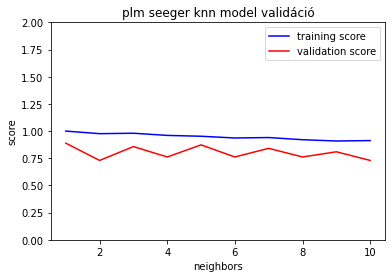

In [30]:
plt.plot(neighbors, np.median(train_score, 1), color='blue', label='training score')
plt.plot(neighbors, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 2)
plt.xlabel('neighbors')
plt.ylabel('score');
plt.title('plm seeger knn model validáció')

Teszteljük le néhány képpel:

In [31]:
test_images = positive_patches[54]